In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
y = pd.read_csv('AAPL_quarterly_financials.csv')
y.head()

,name,ttm,09/30/2023,06/30/2023,03/31/2023,12/31/2022,09/30/2022,06/30/2022,03/31/2022,12/31/2021,...,12/31/1987,09/30/1987,06/30/1987,03/31/1987,12/31/1986,09/30/1986,06/30/1986,03/31/1986,12/31/1985,09/30/1985
0,TotalRevenue,"383,285,000,000","89,498,000,000","81,797,000,000","94,836,000,000","117,154,000,000","90,146,000,000","82,959,000,000","97,278,000,000","123,945,000,000",...,"1,042,400,000","786,500,000","637,100,000","575,300,000","662,300,000","510,800,000","448,300,000","408,900,000","533,900,000","409,700,000"
1,\tOperatingRevenue,"383,285,000,000","89,498,000,000","81,797,000,000","94,836,000,000","117,154,000,000","90,146,000,000","82,959,000,000","97,278,000,000","123,945,000,000",...,"1,042,400,000","786,500,000","637,100,000","575,300,000","662,300,000","510,800,000","448,300,000","408,900,000","533,900,000","409,700,000"
2,CostOfRevenue,"214,137,000,000","49,071,000,000","45,384,000,000","52,860,000,000","66,822,000,000","52,051,000,000","47,074,000,000","54,719,000,000","69,702,000,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GrossProfit,"169,148,000,000","40,427,000,000","36,413,000,000","41,976,000,000","50,332,000,000","38,095,000,000","35,885,000,000","42,559,000,000","54,243,000,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OperatingExpense,"54,847,000,000","13,458,000,000","13,415,000,000","13,658,000,000","14,316,000,000","13,201,000,000","12,809,000,000","12,580,000,000","12,755,000,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc["BasicEPS",:]).iloc[2:,:]

In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
y = y.sort_index().fillna(0.)

In [7]:
y=y.loc["2004-03-31":]

# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [8]:
#pip install pytrends

In [9]:
from pytrends.request import TrendReq

In [24]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Samsung", "Recession",'Huawei','Buy iPhone',"CPI","new phone","Drake","USC","UCLA"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [36]:
df.resample("Q").mean().head()

,Samsung,Recession,Huawei,Buy iPhone,CPI,new phone,Drake,USC,UCLA
date,,,,,,,,,
2004-03-31,24.000000,7.333333,0.0,0.000000,24.666667,45.333333,14.333333,51.333333,86.666667
2004-06-30,24.000000,7.666667,1.0,0.000000,50.333333,48.333333,13.666667,42.666667,85.000000
2004-09-30,26.333333,5.666667,1.0,0.333333,0.000000,49.000000,13.666667,59.000000,75.333333
2004-12-31,29.333333,7.333333,1.0,0.000000,23.000000,45.000000,16.000000,69.000000,83.000000
2005-03-31,27.666667,6.000000,1.0,0.000000,0.000000,43.333333,18.000000,62.666667,81.666667


In [26]:
# Resample the data to get quarterly averages
df_resampled = df.resample("Q").mean()

In [27]:
# Handling missing values by filling NaN with 0
df_resampled = df_resampled.fillna(0)

In [28]:
# Assuming df_resampled is your input data (X)
X = df_resampled
X = X[X.index.isin(y.index)]

In [29]:
y = y[y.index.isin(X.index)]

# 2.) Normalize all the X data

In [16]:
from sklearn.preprocessing import StandardScaler

In [33]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
#from sklearn.model_selection import train_test_split

# First split: 80% train, 20% for test and holdout
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: of the 20% for test and holdout, split into 75% test and 25% holdout
# This will result in 15% of the original data in test and 5% in holdout
#X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 3.) Run a Lasso with lambda of .5 and Plot a bar chart.

In [21]:
from sklearn.linear_model import Lasso

In [34]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_scaled, y)
Coefficients = lasso.coef_

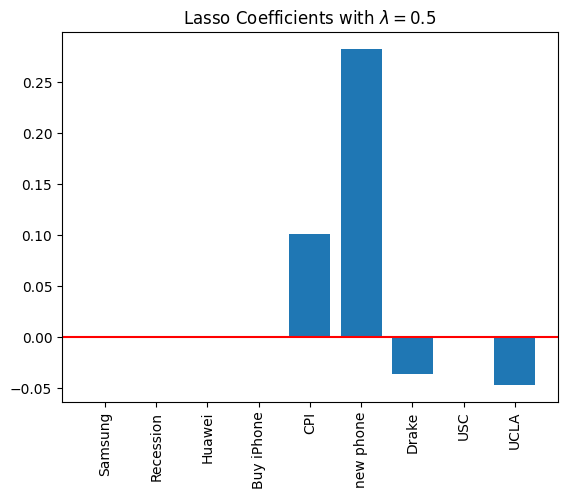

In [35]:
plt.bar(range(len(Coefficients)), Coefficients)
X_column_names = X.columns
plt.xticks(range(len(Coefficients)), X_column_names, rotation='vertical')
plt.axhline(0, color="red")
plt.title('Lasso Coefficients with $\lambda = 0.5$')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

The keyword "new phone" has a significantly larger positive coefficient than the others, suggesting that it is the most positively correlated with the BasicEPS. This makes sense because Apple's annual new product launches can lead to significant fluctuations in stock prices, and investors around the world are concerned about it. In addition, the coefficient "CPI" is a marcro index which can influence the whole stock market, which could contribute to the Basic EPS. However, the variables "Drake" and "UCLA" doesn't make sense since they are supposed uncorrelated with the Basic EPS of Apple.  

The keywords "Samsung," "Recession," "Huawei," "Buy iPhone," and "USC,"  have much smaller coefficients, suggesting that they have a weaker relationship with the dependent variable. The coefficients of some keywords might be very close to zero or exactly zero, which often happens with Lasso regression. This method is for producing sparse solutions, meaning that it can reduce the coefficients of less important variables to zero, effectively performing feature selection.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

In [ ]:
#alphas = np.logspace(0, 6, 10)
#coefs = []

#coef = np.nan * np.ones((len(l_sim), X_scaled.shape[1]))
#for i, l in enumerate(l_sim):
    #lasso = Lasso(alpha=l)
    #lasso_result = lasso.fit(X_scaled,y)
    #coef[i,:] = lasso_result.coef_


In [ ]:
#plt.figure(figsize=(10,10))
#for i in range(coef.shape[1]):
    #plt.plot(
        #l_sim, coef[:,i],
        #label=df.columns[i],
        #linewidth=4)
#plt.legend(
    #df.columns,
    #fontsize=12,)
#plt.title('Lasso Coefficients', fontsize=20)
#plt.xlabel('$\lambda$', fontsize=20)
#plt.ylabel('Coefficient', fontsize=20)

# 7.) Run a cross validation. What is your ideal lambda?

In [ ]:
#from sklearn.linear_model import LassoCV

#modCV = LassoCV(cv=5).fit(X_scaled,y)

In [ ]:
#opt_l = modCV.alpha_
#opt_coef = modCV.coef_
#print(f'Optimal lambda: {np.round(opt_l, 5)}')

In [ ]:
#plt.barh(df.columns, opt_coef)
#plt.title(f'Lasso Coefficients with optimal $\lambda = {np.round(opt_l, 5)}$')
#plt.plot()